In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.metrics
%matplotlib inline

## Problem 1: Digit Recognizer

### a)

In [0]:
train = pd.read_csv("train_digit.csv")
test = pd.read_csv("test_digit.csv")


### b) We create a function to display a digit  

In [0]:
def MNISTdigit(rowindex):
  img = np.array(train.iloc[rowindex,1:]).reshape(-1,28)
  plt.imshow(img, cmap = 'Greys')
  plt.show()

and we print the first instance of every digit in the training set

In [0]:
for i in range(0,10):
  row = 0
  while train.iloc[row,0] != i:
    row += 1
  MNISTdigit(row)  
  

### c) We use the value_counts function to get the normalized count of each digit and plot the corresponding histogram

Text(0.5, 1.0, 'Normalized histogram of digit counts')

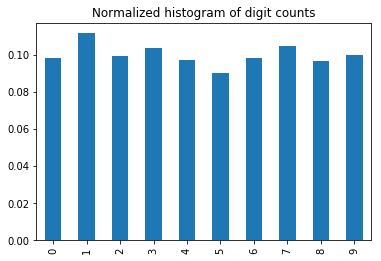

In [6]:
train['label'].value_counts(sort = False , normalize = True).plot('bar', )
plt.title('Normalized histogram of digit counts')

It is relatively even, with the digit 5 being the most infrequent and 1 the most frequent.

### d) We start by getting the index of the first instance of each digit

In [0]:
 index = []
for i in range(0,10):
  row = 0
  while train.iloc[row,0] != i:
    row += 1
  index.append(row)


Then, for each digit calculate the euclidean distance between itself and the rest of the training data. Choose the second value to exclude itself

In [0]:
train_array = train.to_numpy()
nearest = []

for i in index:
  l2_dist = np.argsort(((train_array[i,1:] - train_array[:,1:])**2).sum(-1))
  nearest.append(l2_dist[1]) 

In [9]:
nearestlabel = []
#for each digit, get the label of its nearest neighbor
for i in nearest:
  nearestlabel.append(train.iloc[i,0])

indexdf = pd.DataFrame(index)
nearestdf = pd.DataFrame(nearest)
nearestlabeldf = pd.DataFrame(nearestlabel)

#create table to compare original digits to nearest neighbor
out = np.transpose(pd.concat([np.transpose(indexdf), np.transpose(nearestdf), np.transpose(nearestlabeldf)]))  
out.columns = ["original index" , "nearest index", "nearest label"]

print(out)

   original index  nearest index  nearest label
0               1          12950              0
1               0          29704              1
2              16           9536              2
3               7           8981              5
4               3          14787              4
5               8          30073              5
6              21          16240              6
7               6          15275              7
8              10          32586              8
9              11          35742              9


Our Number 3's closest neighbor is a Number 5. Other than that every other's nearest neighbor was itself.

### e)

In [0]:
#get and store just the zeros and ones from the training data
zeros = train[train.iloc[:,0] == 0]
ones = train[train.iloc[:,0] == 1]

#row bind these two to create one large dataframe
zo = pd.concat([zeros, ones])
zo = zo.to_numpy()
zo = zo[:,1:]

In [0]:
#calculate the pairwise distances for the above
dis = sklearn.metrics.pairwise.euclidean_distances(zo)

In [0]:
#use the size of each of the ones and zeros to pull the upper left
#and bottom right of the matrix (genuine 0 and genuine 1 respectively).
#flatten.
genzero = np.ndarray.flatten(dis[:zeros.shape[0],:zeros.shape[0]])
genone = np.ndarray.flatten(dis[zeros.shape[0]:,zeros.shape[0]:])

#use the size of each of the ones and zeros to pull the upper right
#and bottom left of the matrix (imposter matches).
#flatten.
imposterbl = np.ndarray.flatten(dis[zeros.shape[0]:,:zeros.shape[0]])
imposterur = np.ndarray.flatten(dis[:zeros.shape[0],zeros.shape[0]:])

#bind all of the genuine and imposter distances together
gen = np.hstack([genzero,genone])
imp = np.hstack([imposterbl, imposterur])


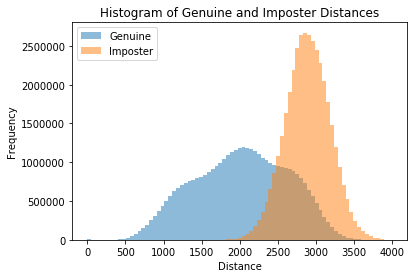

In [13]:
#plot the genuine and imposter distances on the same plot
bins = np.linspace(0, 4000, 80)

plt.hist(gen, bins, alpha = 0.5, label = 'Genuine')
plt.hist(imp, bins, alpha = 0.5, label = 'Imposter')
plt.legend(loc = 'upper left')
plt.title('Histogram of Genuine and Imposter Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

###f)

In [0]:
#use zero to mark genuine matches
markg = np.zeros(gen.shape)

#use one to mark imposter matches
marki = np.ones(imp.shape)

In [0]:
#create two master vectors of distances and corresponding labels
dist = np.hstack([gen, imp])
mark = np.hstack([markg, marki])

In [0]:
#use sklearn's roc_curve() to calculate the roc curve
fpr, tpr, threshold = sklearn.metrics.roc_curve(mark, dist)

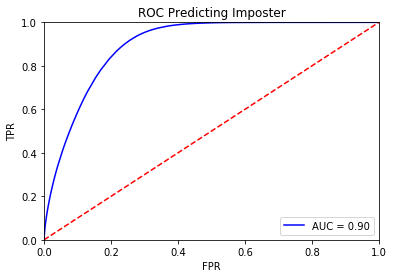

In [19]:
#plot ROC curve with AUC
roc_auc = sklearn.metrics.auc(fpr, tpr)


plt.title('ROC Predicting Imposter')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [23]:
EER_fpr = fpr[np.nanargmin(np.absolute(((1-tpr) - fpr)))]
EER_tpr = tpr[np.nanargmin(np.absolute(((1-tpr) - fpr)))]
print(EER_fpr, EER_tpr)


0.18554784422124979 0.814452073876342


In [68]:
print('The error of a classifier that simply guesses randomly is 50%')

The error of a classifier that simply guesses randomly is 50%


### g)

In [0]:
#create function to run KNN. take in a training set, test set, and k.
#output 3 arrays: (1) the actual labels (2) the nearest distances
#(3) the labels of the nearest neighbors

#trainSet includes the label in the first column
#testSet does not include the first column
def KNNtrain(trainSet, testSet, k):
  nearest = np.zeros((testSet.shape[0],k))
  nearestlabels = np.zeros((testSet.shape[0],k))
  
  
  for i in range(testSet.shape[0]):
    l2_dist = np.argsort(((testSet[i,:] - trainSet[:,1:])**2).sum(-1))
    nearest[i,:] = l2_dist[0:k]
  
  for i in range(nearest.shape[0]):
    for j in range(nearest.shape[1]):
      nearestlabels[i,j] = trainSet[int(nearest[i,j]),0]
  
  
  return(nearest, nearestlabels)

In [0]:
#split training set into two halves
trainSet = train.sample(frac = 0.5, random_state = 200)
testSet = train.drop(trainSet.index)

trainSet = trainSet.to_numpy()


testSet = testSet.to_numpy()
testActual = testSet[:,0]
testSet = testSet[:,1:]



In [0]:
#run the knn algorithm on the prior created training and test sets
neighbor, labels = KNNtrain(trainSet, testSet, k = 5)

In [0]:
#make a prediction based on the majority vote k nearest neighbors
def KNNPred(labels):
  
  prediction = np.zeros(labels.shape[0])
  for i in range(labels.shape[0]):
    vote = stats.mode(labels[i,:])[0][0]
    prediction[i] = vote
  return prediction

### h) We now train the k-NN classifier on the first half of the data, and test it on the second half, reporting our average accuracy.

In [0]:
#run on knn model created from test and training datasets
prediction = KNNPred(labels)

In [0]:
from sklearn.metrics import confusion_matrix

#build confusion matrix from prediction and actual of test set
cm = confusion_matrix(testActual, prediction)
acc = np.trace(cm)/np.sum(cm)
acc*100


96.11428571428571

### i) 10x10 confusion matrix

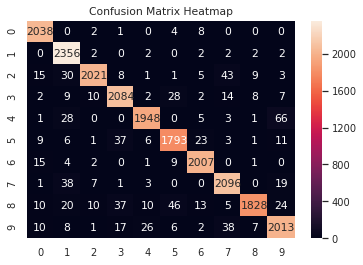

In [0]:
import seaborn as sns
sns.set(font_scale = 0.9)
conf_map = sns.heatmap(cm, annot = True, fmt='d')
conf_map.set_title('Confusion Matrix Heatmap')
plt.show()

### j) Training the classifier with all of the training data, and testing with the test data.

In [0]:
train = train.to_numpy()
test = test.to_numpy()


neighbor_final, labels_final = KNNtrain(train, test, k = 5)
Label = KNNPred(labels_final)

In [0]:
ImageId = range(1, len(Label)+1)
submit = pd.DataFrame({'ImageId': ImageId, 'Label': Label}, columns=['ImageId', 'Label'])
submit.to_csv('submission_digit.csv', index = False)